In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import dicom as dicom
import os
import glob
import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from sklearn.preprocessing import LabelEncoder
import time
#from mpl.toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib inline
print('Hello')

Hello


In [2]:
# Download patient IDs and labels
data_dir = 'C:\TCIA-BRCA\DOI'
patients = os.listdir(data_dir)
labels_brca = pd.read_csv('D:\Insight\clin.txt',sep='\t',#names=['patients','class'],
                          #index_col=0,
                          na_values='NA',
                          usecols=['patient.bcr_patient_barcode','class','patient.stage_event.pathologic_stage'] )
patients.sort()
#print patients
labels_brca.rename(index=str, columns={"patient.bcr_patient_barcode": "patients",
                                      'patient.stage_event.pathologic_stage': 'class2'}, inplace=True)
labels_brca['patients'] = labels_brca['patients'].str.upper()
print(len(patients), len(labels_brca))
print(labels_brca.head())

139 1097
       patients     class2  class
0  TCGA-5L-AAT0  stage iia  early
1  TCGA-5L-AAT1   stage iv   late
2  TCGA-A1-A0SP  stage iia  early
3  TCGA-A2-A04V  stage iia  early
4  TCGA-A2-A04Y  stage iib  early


In [13]:
#print(labels_brca.iloc[5:10,"class2"])
#print(labels_brca["class2"].head())
#print(np.unique(labels_brca["class2"]))

In [3]:
# Label Encoder
encoder = LabelEncoder()
encoder.fit(labels_brca["class"])
labels_brca['y'] = encoder.transform(labels_brca["class"])
print (labels_brca.iloc[:,1:4].head())
#print labels_brca['y'].head()

      class2  class  y
0  stage iia  early  0
1   stage iv   late  1
2  stage iia  early  0
3  stage iia  early  0
4  stage iib  early  0


In [120]:
import os
data_dir = 'C:\TCIA-BRCA\DOI'
patient_list=[]
labels = []
for root, dirs, files in os.walk(data_dir):
    if dirs == []:
        if (len(files) >= 20 
            #and dicom.read_file(os.path.join(root, files[0])).Modality =='MR'
           ):
            patient = dicom.read_file(os.path.join(root, files[0])).PatientID
            scans = [dicom.read_file(os.path.join(root, filename)) for filename in files]
            #scans.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            patient_list.append(patient)
            label = labels_brca['y'][labels_brca['patients']==patient].values
            labels.append(label)
print (len(scans))
print (len(patient_list))
print (len(labels))

KeyboardInterrupt: 

In [121]:
print (len(scans))

390


In [267]:
# Resolving path to dcm files

data_dir = 'C:\TCIA-BRCA\DOI'
patients = os.listdir(data_dir)

#print data_dir
#print patients[1]
path1 = data_dir + '/' + patients[0]
files1 = os.listdir(path1)
#print path1
path2 = path1 +  '/' + files1[0]
files2 = os.listdir(path2)
#print path2[0]
path3 = path2 +  '/' + files2[0]
files3 = os.listdir(path3)
#print path3
path4 = path3 + '/' + files3[0]
#print (path4)
#test =[dicom.read_file(path3 + '/' + s) for s in os.listdir(path3)]
#print test[0].Modality

C:\TCIA-BRCA\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.105050108785380600324694049408/000000.dcm


In [125]:
scan_paths= []
for patient in os.listdir(data_dir):
    path1 = data_dir + '/' + patient
    for y in os.listdir(path1):
        path2 = path1 + '/' + y
        for scan in os.listdir(path2):
            scan_paths.append(path2 + '/' + scan)
scan_paths.sort()
print(len(scan_paths))

1877


In [315]:
#print(scan_paths[:10])

In [ ]:
slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path) for scan_path in scan_paths[:5]
          if (dicom.read_file(path3+'/'+ s)).Modality =='MR'
          if len(os.listdir(path3))>=20
         ]
print(len(slices))
print(slices[0].Modality)

In [325]:
for scan_path in scan_paths[:5]:
    slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)
                            if (dicom.read_file(path3+'/'+ s)).Modality =='MR'
                            if len(os.listdir(path3))>=20
                            ]
print(len(slices))
print(slices[0])

33
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.9203.4002.138380511062229359665509599803
(0008, 0020) Study Date                          DA: '20010315'
(0008, 0021) Series Date                         DA: '20010315'
(0008, 0022) Acquisition Date                    DA: '20010315'
(0008, 0023) Content Date                        DA: '20010315'
(0008, 0030) Study Time                          TM: '115359'
(0008, 0031) Series Time                         TM: '120016'
(0008, 0032) Acquisition Time                    TM: '120016'
(0008, 0033) Content Time                        TM: '120016'
(0008, 0050) Accession Number                    SH: '2562332516979364'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufactur

In [296]:
data_dir = 'C:\TCIA-BRCA\DOI'
#scans= []
Modality = []
patient_id=[]
views = []
labels = []

for patient in os.listdir(data_dir)[:3]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path1 = data_dir + '/' + patient
    for y in os.listdir(path1):
        path2 = path1 + '/' + y
        for z in os.listdir(path2)[:2]:
            path3 = path2 + '/' + z
            scans = [dicom.read_file(path3 + '/' + s) for s in os.listdir(path3)
                    if (dicom.read_file(path3+'/'+ s)).Modality =='MR'
                    if len(os.listdir(path3))>=20
                    ]
            scans.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            #print(len(scans),scans[0].pixel_array.shape, scans[0].CodeMeaning,scans[0].PatientID,scans[0].Modality)
            #views.append(scans[0].ProtocolName)
            if scans:
                patient_id.append(scans[0].PatientID)
                Modality.append(scans[0].Modality)
                labels.append(label)
#           for dcm in os.listdir(path3):
#           print (path3 + '/' + dcm)
print (len(scans))
print(patient_id[:5])
#print(views[:5])
print(Modality[:5])

100
['TCGA-AO-A03M', 'TCGA-AO-A03V', 'TCGA-AO-A03V', 'TCGA-AO-A0J8', 'TCGA-AO-A0J8']
['MR', 'MR', 'MR', 'MR', 'MR']


In [19]:
print (len(scans))
print(len(patient_id))
#print(views[:5])
print(len(Modality))

NameError: name 'scans' is not defined

In [307]:
#[scan.pixel_array.shape for scan in scans]
#print(scans)

In [19]:
# extracting paths to patient dcm using nested for loop
listp = []
for patient in patients[:1]:
    #label = labels_brca.get_value(patient,'class2')
    [listp.append(data_dir+'/'+patient+'/'+x+'/'+y+'/'+z) 
                  for x in os.listdir(data_dir+'/'+patient) 
     for y in os.listdir(data_dir+'/'+patient+'/'+x)[:1]
     for z in os.listdir(data_dir+'/'+patient+'/'+x+'/'+y) ]
    #slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
#print listp[0]

In [28]:
# get class value for each patient
#df.B.values[df.A.values == 23] # 60.3 µs per loop
#df['B'].loc[df.A.values == 23] #  197 µs
#print labels_brca['y'][labels_brca['patients']=='TCGA-AO-A03M']
#print labels_brca.loc[labels_brca['patients'] == 'TCGA-AO-A03M']

381    0
Name: y, dtype: int64


In [97]:
# read in dicom to array of lists with metadata
for patient in patients[:4]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1]
     for z in os.listdir(path+'/'+x+'/'+y)[:1] ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    print len(slices), slices[0].pixel_array.shape, slices[0].SliceThickness, label 
    #print slices[0].SeriesDescription, slices[0].PatientOrientation

1 (512L, 512L) 3 [0]
1 (256L, 256L) 3 [0]
1 (256L, 256L) 3 [0]
1 (256L, 256L) 3 [1]


In [8]:
# exclude non-MRI studies
for patient in patients[35:40]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
             if len(os.listdir(path+'/'+x+'/'+y))>=12
             ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    #if len(slices) > 112 :
    print len(slices)#, slices[0].pixel_array.shape, slices[0].SliceThickness, label 
    #print slices[0].SeriesDescription, slices[0].PatientOrientation
    #mod = []
    #mod = [x if x.Modality == 'MR' for x in slices]
    #mod = [x.Modality for x in slices]
    #print mod
    # [a if C else b for i in items]
    # [x+1 if x >= 45 else x+5 for x in l]
    # [y for y in a if y not in b]
    # [ expression for item in list if conditional ]
    #print slices[0]
    #print slices[0].SOPClassUID
    #print slices[0].Modality
    #plt.imshow(slices[10].pixel_array)
    #plt.show()
#slices = [slice for slice in slices if len(slices) > 5 ]

SyntaxError: invalid syntax (<ipython-input-8-c594a8e9456e>, line 15)

In [200]:
# exclude scans less than 12 slices
for patient in patients[35:40]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices =[]
    for x in os.listdir(path):
        for y in os.listdir(path+'/'+x)[:1]:
            for z in os.listdir(path+'/'+x+'/'+y):
                if len(os.listdir(path+'/'+x+'/'+y))>=12:
                    #print len(os.listdir(path+'/'+x+'/'+y))
                    if ((dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
                        and len(os.listdir(path+'/'+x+'/'+y))>=12):
                        slices.append(dicom.read_file(path+'/'+x+'/'+y+'/'+z))
            
    #'{}{}{}'.format()
#    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
#                  for x in os.listdir(path) 
#     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
#     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
#              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
#             if len(os.listdir(path+'/'+x+'/'+y))>=12]
    
                        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if slices :
        print len(slices), slices[0].pixel_array.shape, slices[0].SliceThickness, label 
    

 70 (512L, 512L) 2.0 [0]
72 (512L, 512L) 2.0 [0]
480 (512L, 512L) 2 [0]
58 (256L, 256L) 7 [0]


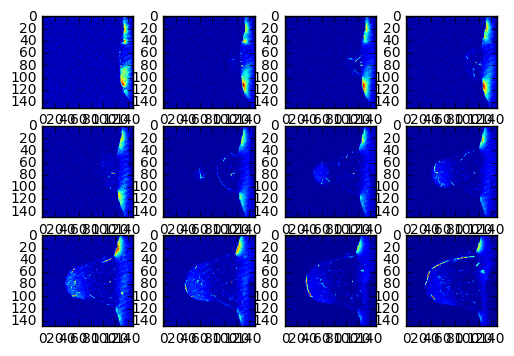

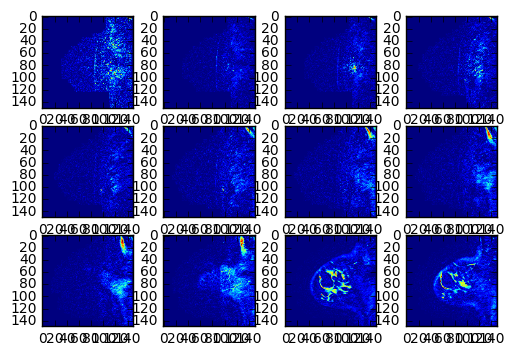

In [107]:
IMG_PX_SIZE = 150

for patient in patients[10:12]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
             and len((dicom.read_file(path+'/'+x+'/'+y+'/'+z)) >=12)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    fig = plt.figure()
    for num, each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_image = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_image)
    plt.show()

In [11]:
IMG_PX_SIZE = 150
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
for patient in patients[5:10]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
             if len(os.listdir(path+'/'+x+'/'+y))>=12
             ]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    
    new_slices = []
    
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices)/HM_SLICES))
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    print (len(slices), len(new_slices))
    '''
    fig = plt.figure()
    for num, each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()
    '''

430 20
46 16
45 15
36 18
53 18


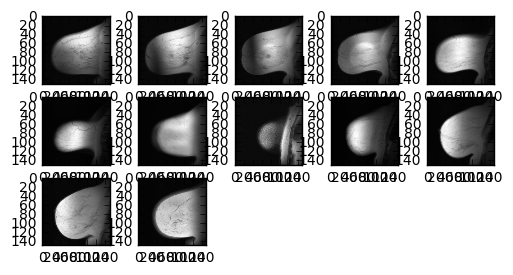

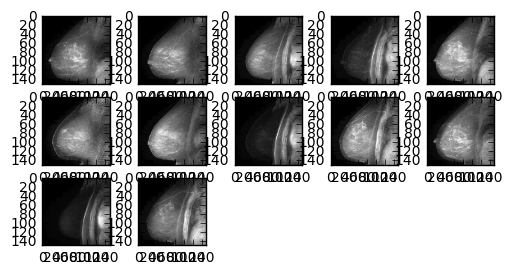

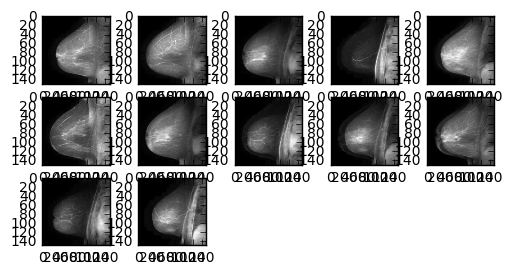

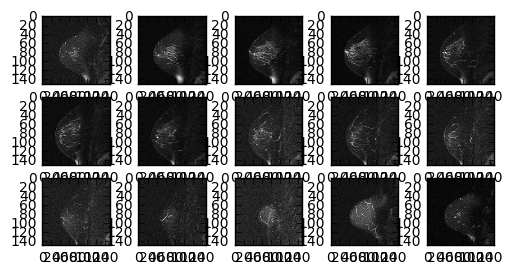

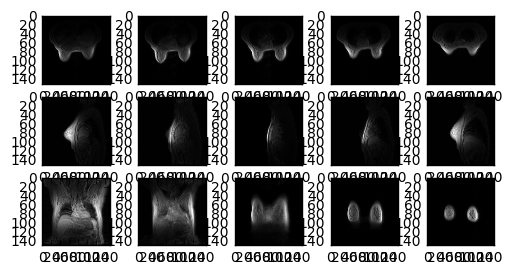

In [125]:
IMG_PX_SIZE = 150
HM_SLICES = 12

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
for patient in patients[100:105]:
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:1] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR']
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    
    new_slices = []
    
    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = int(math.ceil(len(slices)/HM_SLICES))
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    #print len(slices), len(new_slices)
    #'''
    fig = plt.figure()
    for num, each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()
    #'''

In [12]:
IMG_PX_SIZE = 50
HM_SLICES = 12

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
def process_data(patient, labels_brca, img_px_size=50, hm_slices=20, visualize=False):
    label = labels_brca['y'][labels_brca['patients']==patient].values
    path = data_dir+'/'+patient
    slices = [dicom.read_file(path+'/'+x+'/'+y+'/'+z)
                  for x in os.listdir(path) 
     for y in os.listdir(path+'/'+x)[:5] # check only first scan 
     for z in os.listdir(path+'/'+x+'/'+y)#[:1] # check only first dicom file
              if (dicom.read_file(path+'/'+x+'/'+y+'/'+z)).Modality =='MR'
               if len(os.listdir(path+'/'+x+'/'+y))>=12
                 ]
    #slices = [x_slice for x_slice in slices if len(x_slice) > 20]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    #print len(slices), slices[0].pixel_array.shape, label
    if slices :
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]

        chunk_sizes = int(round(len(slices)/HM_SLICES))

        for slice_chunk in chunks(slices,chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        #print len(slices), len(new_slices)
        if visualize:
            fig = plt.figure()
            for num, each_slice in enumerate(new_slices):
                y = fig.add_subplot(4,5,num+1)
                y.imshow(each_slice, cmap='gray')
            plt.show()

        if label==1:
            label = np.array([0,1])
        elif label==0:
            label = np.array([1,0])

        return np.array(new_slices), label
    
    else :
        return [], label

much_data = []
for num, patient in enumerate(patients):
    if num%5==0:
        print (num)
        
    try:
        img_data, label = process_data(patient, labels_brca, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        
        if (img_data != [] and img_data.shape == (12, 50, 50)):
            print (img_data.shape, label)
            much_data.append([img_data, label])
    except KeyError as e:
        print ('unlabeled')
        
#np.save('muchdata-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

0


c:\users\toby\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:81: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


(12, 50, 50) [1 0]
(12, 50, 50) [1 0]
(12, 50, 50) [1 0]
(12, 50, 50) [0 1]
(12, 50, 50) [1 0]
5


KeyboardInterrupt: 

In [383]:
print(scan_paths[:3])
print('Hello')

['C:\\TCIA-BRCA\\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.105050108785380600324694049408', 'C:\\TCIA-BRCA\\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.106067388983457614790455949431', 'C:\\TCIA-BRCA\\DOI/TCGA-AO-A03M/1.3.6.1.4.1.14519.5.2.1.9203.4002.283279901761013891636519880891/1.3.6.1.4.1.14519.5.2.1.9203.4002.112423030568957082578123456874']
Hello


In [164]:
# more images

data_dir = 'C:\TCIA-BRCA\DOI'

IMG_PX_SIZE = 50
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
def process_data(scan_path, labels_brca, img_px_size=50, hm_slices=20, visualize=False):
    #print(scan_path)
    slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)]
    #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    if (slices[0].Modality=='MR' and len(slices)>=20) :
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        patient = slices[0].PatientID
        label = labels_brca['y'][labels_brca['patients']==patient].values
        #print (patient, len(slices), slices[0].pixel_array.shape, label,slices[0].Modality)
        
        new_slices = []

        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        #img = cv.resize(img, (800, 800))
        #cv.normalize(img, img, 0, 255, cv.NORM_MINMAX)

        chunk_sizes = int(round(len(slices)/HM_SLICES))

        for slice_chunk in chunks(slices,chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)
        
        if len(new_slices) == HM_SLICES-1:
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES-2:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            
        if len(new_slices) == HM_SLICES-3:
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])
            new_slices.append(new_slices[-1])

        if len(new_slices) == HM_SLICES+2:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val

        if len(new_slices) == HM_SLICES+1:
            new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES]
            new_slices[HM_SLICES-1] = new_val
        
        if len(new_slices) == HM_SLICES+3:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-2] = new_val
        
        if len(new_slices) == HM_SLICES+4:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-3] = new_val
            
        if len(new_slices) == HM_SLICES+5:
            #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
            del new_slices[HM_SLICES:]
            #new_slices[HM_SLICES-3] = new_val

        if visualize:
            fig = plt.figure()
            for num, each_slice in enumerate(new_slices):
                y = fig.add_subplot(4,5,num+1)
                y.imshow(each_slice, cmap='gray')
                plt.show()
        
        if label==1:
            label = np.array([0,1])
        elif label==0:
            label = np.array([1,0])

        return np.array(new_slices), label, patient

    else :
        label = 0
        patient = ''
        return np.empty([1,1]), label , patient

much_data_patient = []
for num, scan_path in enumerate(scan_paths):
    if num%100==0:
        print (num)
        
    try:
        img_data, label, patient = process_data(scan_path, labels_brca, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        #print (img_data.shape, label)
        if img_data.shape == (20, 50, 50):
            #print (img_data.shape, label)
            much_data_patient.append([img_data, label, patient])
    except KeyError as e:
        print ('unlabeled')

len(much_data_patient)
#np.save('muchdata-norm-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


1554

In [167]:
np.save('muchdata-patient-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data_patient)

In [415]:
#np.save('muchdata-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

In [166]:
much_data_patient[0]

[array([[[   0. ,    0. ,    0. , ...,   70.5,   53. ,   29. ],
         [   0. ,    0. ,    0. , ...,   76. ,   58. ,   32. ],
         [   0. ,    0. ,    0. , ...,   35.5,   42. ,   38.5],
         ..., 
         [   0. ,    0. ,    0. , ...,   38. ,   38. ,    8. ],
         [   0. ,    0. ,    0. , ...,   26.5,   27. ,   23.5],
         [   0. ,    0. ,    0. , ...,   60.5,   26.5,   31.5]],
 
        [[   0. ,    0. ,    0. , ...,   98. ,   75. ,   41.5],
         [   0. ,    0. ,    0. , ...,   72.5,   19.5,   45. ],
         [   0. ,    0. ,    0. , ...,   24. ,   57.5,   93.5],
         ..., 
         [   0. ,    0. ,    0. , ...,   31. ,   34.5,   36. ],
         [   0. ,    0. ,    0. , ...,   42. ,   53.5,   34.5],
         [   0. ,    0. ,    0. , ...,   33.5,   42.5,   38. ]],
 
        [[   0. ,    0. ,    0. , ...,   53. ,   27.5,   10.5],
         [   0. ,    0. ,    0. , ...,   21. ,   43.5,   34.5],
         [   0. ,    0. ,    0. , ...,   89. ,   80. ,   57. ],
    

In [146]:
# trim scan path and extract patient ID
print(scan_paths[0][17:29])

TCGA-AO-A03M


In [161]:
# store images with positive label (late stage cancers for upsampling or image augmentation)

data_dir = 'C:\TCIA-BRCA\DOI'

IMG_PX_SIZE = 50
HM_SLICES = 20

def chunks(l,n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in range(0,len(l), n):
        yield l[i:i+n]

def mean(l):
    return sum(l)/len(l)
        
def process_data(scan_path, labels_brca, img_px_size=50, hm_slices=20, visualize=False):
    #print(scan_path)
    patient = scan_path[17:29]
    label = labels_brca['y'][labels_brca['patients']==patient].values
    #print (label)
    if label == 1:
        #print(label) 
        slices = [dicom.read_file(scan_path + '/' + s) for s in os.listdir(scan_path)]
        #print(len(slices))
        #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        if (slices[0].Modality=='MR' and len(slices)>=20) :
            slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            patient = slices[0].PatientID
            label = labels_brca['y'][labels_brca['patients']==patient].values
            #print (patient, len(slices), slices[0].pixel_array.shape, label,slices[0].Modality)

            new_slices = []

            slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
            #img = cv.resize(img, (800, 800))
            #cv.normalize(img, img, 0, 255, cv.NORM_MINMAX)

            chunk_sizes = int(round(len(slices)/HM_SLICES))

            for slice_chunk in chunks(slices,chunk_sizes):
                slice_chunk = list(map(mean, zip(*slice_chunk)))
                new_slices.append(slice_chunk)

            if len(new_slices) == HM_SLICES-1:
                new_slices.append(new_slices[-1])

            if len(new_slices) == HM_SLICES-2:
                new_slices.append(new_slices[-1])
                new_slices.append(new_slices[-1])

            if len(new_slices) == HM_SLICES-3:
                new_slices.append(new_slices[-1])
                new_slices.append(new_slices[-1])
                new_slices.append(new_slices[-1])

            if len(new_slices) == HM_SLICES+2:
                new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
                del new_slices[HM_SLICES]
                new_slices[HM_SLICES-1] = new_val

            if len(new_slices) == HM_SLICES+1:
                new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
                del new_slices[HM_SLICES]
                new_slices[HM_SLICES-1] = new_val

            if len(new_slices) == HM_SLICES+3:
                #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
                del new_slices[HM_SLICES:]
                #new_slices[HM_SLICES-2] = new_val

            if len(new_slices) == HM_SLICES+4:
                #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
                del new_slices[HM_SLICES:]
                #new_slices[HM_SLICES-3] = new_val

            if len(new_slices) == HM_SLICES+5:
                #new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
                del new_slices[HM_SLICES:]
                #new_slices[HM_SLICES-3] = new_val

            if visualize:
                fig = plt.figure()
                for num, each_slice in enumerate(new_slices):
                    y = fig.add_subplot(4,5,num+1)
                    y.imshow(each_slice, cmap='gray')
                    plt.show()

            if label==1:
                label = np.array([0,1])
            elif label==0:
                label = np.array([1,0])

            return np.array(new_slices), label, patient

        else :
            label = 99
            patient = ''
            return np.empty([1,1]), label, patient
    else:
        label = 99
        patient = ''
        return np.empty([1,1]), label, patient
        
pos_data_patients = []
for num, scan_path in enumerate(scan_paths):
    if num%25==0:
        print (num)
        
    try:
        img_data, label, patient = process_data(scan_path, labels_brca, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        #print (img_data.shape, label)
        if img_data.shape == (20, 50, 50):
            #print (img_data.shape, label)
            #print (num, ' pos image')
            pos_data_patients.append([img_data, label, patient])
    except KeyError as e:
        print ('unlabeled')

len(pos_data_patients)
#np.save('muchdata-norm-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875


89

In [4]:
pos_data_patients[0][2]

NameError: name 'pos_data_patients' is not defined

In [162]:
# save positive images
np.save('pos-patients-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), pos_data_patients)

In [139]:
print(len(pos_data))
pos_data_array = np.asarray(pos_data)
print(pos_data_array.shape)

89
(89, 1, 20, 50, 50)


combine original and augmented positive patients into one array, then split into train and validation sets for training

In [2]:
orig_patients = np.load('muchdata-patient-50-50-20.npy')

In [3]:
aug_patients = np.load('augmented-images-50-50-20.npy')

In [6]:
aug_patients[0][0].shape

(20, 50, 50)

In [7]:
# get list of unique patients and split into train and validation sets
data_dir = 'C:\TCIA-BRCA\DOI'
patients = os.listdir(data_dir)
patients = list(set(patients))
patients.sort()
#print(labels_brca.head())
patient_labels = []
for patient in patients:
    label = int(labels_brca['y'][labels_brca['patients']==patient].values)
    patient_labels.append(label)

print(patients[:10])
print(patient_labels[:10])

['TCGA-AO-A03M', 'TCGA-AO-A03V', 'TCGA-AO-A0J8', 'TCGA-AO-A0J9', 'TCGA-AO-A0JB', 'TCGA-AO-A0JF', 'TCGA-AO-A0JI', 'TCGA-AO-A0JM', 'TCGA-AO-A129', 'TCGA-AO-A12D']
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [8]:
# split into train and test
from sklearn.model_selection import train_test_split

X, y = patients, patient_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

104 104
35 35


In [9]:
from collections import Counter
print(Counter(patient_labels))
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 131, 1: 8})
Counter({0: 99, 1: 5})
Counter({0: 32, 1: 3})


In [10]:
print(X_test[:10])

['TCGA-E2-A14T', 'TCGA-E2-A15H', 'TCGA-EW-A3E8', 'TCGA-AR-A24X', 'TCGA-AO-A0JB', 'TCGA-E2-A1IG', 'TCGA-BH-A0BG', 'TCGA-E2-A14P', 'TCGA-BH-A0B6', 'TCGA-E2-A14V']


In [10]:
# check each of the 1554 elements of much_data_patient (a list of lists [image, label, patient])
# if index[2] (patient ID) in X_train, assign that [scan, label] to train_set
# else assign elem to validation_set
orig_and_aug = [orig_patients,aug_patients]
validation_set=[]
train_set=[]
for group in orig_and_aug:
    for num, elem in enumerate(group):
        img = elem[0]
        # normalize
        mean = np.mean(img)
        stdev = np.std(img)
        #print(mean,stdev)
        if stdev!=0:
            img = img-mean
            img = img/stdev
            #print(mean,stdev)
            if elem[2] in X_test:
                validation_set.append([np.array(img),np.array(elem[1])])
            else:
                train_set.append([np.array(img),np.array(elem[1])])
        if num%50==0:
            print (num, 'Done!')

print(len(validation_set), len(train_set))
# repeat same process for pos_data_patients

0 Done!
50 Done!
100 Done!
150 Done!
200 Done!
250 Done!
300 Done!
350 Done!
400 Done!
450 Done!
500 Done!
550 Done!
600 Done!
650 Done!
700 Done!
750 Done!
800 Done!
850 Done!
900 Done!
950 Done!
1000 Done!
1050 Done!
1100 Done!
1150 Done!
1200 Done!
1250 Done!
1300 Done!
1350 Done!
1400 Done!
1450 Done!
1500 Done!
1550 Done!
0 Done!
50 Done!
100 Done!
150 Done!
200 Done!
250 Done!
300 Done!
350 Done!
400 Done!
450 Done!
500 Done!
550 Done!
600 Done!
650 Done!
700 Done!
750 Done!
800 Done!
850 Done!
747 1685


In [12]:
# save train and validation images
IMG_PX_SIZE = 50
HM_SLICES = 20
np.save('validation-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), validation_set)
np.save('train-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), train_set)

In [ ]:
# space

In [498]:
from sklearn.preprocessing import StandardScaler
#print (much_data[:2])
much_data_array = np.asarray(much_data)
#print (much_data_array[:2,1])

much_data_img = much_data_array[:,0]
much_data_label = much_data_array[:,1]
much_data_label = much_data_label.reshape(much_data_label.shape[0],1)

print(much_data_label.shape)
print(len(much_data_label))
print(much_data_label[:4])
#print (much_data_array[:2,0])
#print (much_data_norm[:1])
#np.save('muchdata-norm-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data_norm)
#print (much_data[:1])

(1554, 1)
1554
[[array([1, 0])]
 [array([1, 0])]
 [array([1, 0])]
 [array([1, 0])]]


In [538]:
sum(x == ([0,1]) for x in much_data[:,1])

array([89, 89])

In [499]:
#much_data_img[1550].shape
much_data_img = np.asarray(much_data_img)
print (much_data_img[1200].dtype)

float64


In [500]:
from sklearn.preprocessing import normalize
#print(much_data_array.shape)
#data_flat = much_data_img.reshape(50*50*20,much_data_img.shape[0])
#print(data_flat.shape)

#scaler = StandardScaler()
#scaler = scaler.fit(much_data_img)
#print (much_data[:1])
#much_data_norm = normalize(much_data_img, axis=0, norm='l1')
#much_data_norm = scaler.transform(much_data_img)

data_mean = np.mean(much_data_img)
data_sd = np.std(much_data_img)
much_data_norm = [(x-data_mean)/data_sd for x in much_data_img]
much_data_norm = np.asarray(much_data_norm)
print(much_data_norm.shape)

(1554, 20, 50, 50)


In [510]:
#print(much_data_norm[:1])
#much_data_array = np.insert(much_data_norm, np.arange(len(much_data_label)), much_data_label, axis=0)
#much_data_array = [y for x in zip(much_data_norm, much_data_label) for y in x]
much_data_array = [x for x in zip(much_data_norm, much_data_label)]
#print(much_data_array[0])
#print(much_data[0])
print(len(much_data_array))
print(len(much_data))

1554
1554


In [501]:
for data in (much_data_norm[:2],much_data_label[:2]):
    #print(data)
    x = data[0]
    y = data[1]
    print(x.shape)
    print(y.shape)

(20, 50, 50)
(20, 50, 50)
(1,)
(1,)


In [511]:
np.save('muchdata-norm-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data_array)

In [ ]:
import pickle
# now you can save it to a file
with open('img_scaler.pkl', 'wb') as img_scale:
    pickle.dump(scaler, img_scale)

# and later you can load it
with open('img_scaler.pkl', 'rb') as img_scale:
    scaler = pickle.load(img_scale)

In [ ]:
# image augmentation

In [4]:
import tensorflow as tf
import numpy as np
print('Hello')

Hello


In [5]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.7

In [6]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

In [7]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_conv3':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
              'b_conv3':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)
    
    conv3 = tf.nn.relu(conv3d(conv1, weights['W_conv3']) + biases['b_conv3'])
    conv3 = maxpool3d(conv3)

#Dimensions must be equal, but are 64 and 32 for 'Conv3D_9' (op: 'Conv3D') with input shapes: [?,13,13,5,64], [3,3,3,32,64].    
    
    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [43]:
#much_data = np.load('muchdata-50-50-20.npy')
#train_data = much_data[:-500]
#validation_data = much_data[-500:]
#print(train_data.shape)

(1054, 2)


In [9]:
#start here
train = np.load('train-50-50-20.npy')
validation = np.load('validation-50-50-20.npy')
print(train.shape)

(1685, 2)


In [14]:
import random
random.seed(5)
idxTrain = random.sample(range(0, len(train)), 1000)
idxTest = random.sample(range(0, len(validation)), 500)
idxTrain[:5]

[1275, 523, 1519, 734, 1628]

In [17]:
train_data= train[idxTrain]
validation_data= validation[idxTest]
print(train_data.shape)
print(validation_data.shape)

(1000, 2)
(500, 2)


In [23]:
y_true = [i[1].tolist() for i in validation_data]
y_true = [0 if i == [1,0] else 1 for i in y_true]
#[xv if c else yv for (c,xv,yv) in zip(condition,x,y)]
#np.where(y_true == np.array([1, 0]), 0, 1)
#y_true = y_true.tolist()
print(y_true[:10])

[0, 1, 0, 1, 0, 0, 1, 1, 1, 1]


In [54]:
#train_data[0]

#### Train_Test_Split without leaking Patients
Patient names must be attached to each scan/image. Unique patient names are extracted and split randomly into 2 groups, train and validation. The group name is then joined (one to many) to all scans. The data is then subset by group tag.
[ item for item in items if item.col2 == 2006 ] 
filter()
import numpy as np
data = np.array([
        [100002, 2006, 1.1, 0.01, 6352],
        [100002, 2006, 1.2, 0.84, 304518],
        [100002, 2006, 2,   1.52, 148219],
        [100002, 2007, 1.1, 0.01, 6292],
        [10002,  2006, 1.1, 0.01, 5968],
        [10002,  2006, 1.2, 0.25, 104318],
        [10002,  2007, 1.1, 0.01, 6800],
        [10002,  2007, 4,   2.03, 25446],
        [10002,  2008, 1.1, 0.01, 6408]    ])

subset1 = data[data[:,0] == 100002]
subset2 = data[data[:,0] == 10002]

In [34]:
print(validation_data[:,1][0])

[1 0]


In [39]:
# count class

#labels_brca.y.value_counts()
#labels_brca.ix[-35:].y.value_counts()
#validation_data[label.value_counts()

#train_data[:,1]
#validation_data[:,1]

sum(x == [1,0] for x in validation_data[:,1])
# valid 413 train 1051 neg
# valid 396 train 572 pos
# valid 809 train 1635

# valid 264, 236 (1,0 - pos)
# train 354, 646 (1,0 - pos)

#np.where(validation_data[:,1]==[1,0]).shape
#np.unique(train_data[:,1])
#unique_elements, counts_elements = np.unique(train_data[:,1].any(), return_counts=True)
#print("Frequency of unique values of the said array:")
#print(np.asarray((unique_elements, counts_elements)))

array([236, 236])

In [19]:
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    saver = tf.train.Saver()
    
    hm_epochs = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        successful_runs = 0
        total_runs = 0
        t0=time.time()
        print('start time: ', t0)
        for epoch in range(hm_epochs):
            t0_epoch=time.time()
            #print(t0_epoch)
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
           
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)
            print ('Epoch', epoch+1, "training time:", round(time.time()-t0_epoch, 3), "s") # the time would be round to 3 decimal in seconds
            t1=time.time()

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            print ('Epoch', epoch+1, "predict time:", round(time.time()-t1, 3), "s")
        
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        #prediction_out=tf.argmax(prediction,1)
        prediction_out = sess.run(prediction, feed_dict={x: [i[0] for i in validation_data]})
        #print ("predictions", prediction_out.eval(feed_dict={x: [i[0] for i in validation_data]}, session=sess))
        
        print(sess.run(tf.argmax(prediction, 1), feed_dict={x: [i[0] for i in validation_data]}))
        #print('\n','then','\n')
        #print(sess.run(prediction, feed_dict={x: [i[0] for i in validation_data]}))
        
        #sess.run(prediction, feed_dict={x: [i[0] for i in validation_data]})
        
        classification = sess.run(tf.argmax(prediction, 1), feed_dict={x: [i[0] for i in validation_data]})
        
        #prediction = tf.nn.softmax(tf.matmul(x,W) + b)
        #feed_dict = {x: [i[0] for i in validation_data]}
        #classification = tf.run(prediction, feed_dict)
        classification2 = prediction.eval({x: [i[0] for i in validation_data]})
        
        #probabilities=tf.argmax(prediction, 1)
        #print ("probabilities", probabilities.eval(feed_dict={x: [i[0] for i in validation_data]}, , keep_prob: 1.0))

        print ("Total time:", round(time.time()-t0, 3), "s")
        
        # save model
        saver.save(sess, 'C:/Users/Toby/ipython notebooks/tf_model4/brca-tf-cnn-model4.ckpt')
        print('fitment percent:',successful_runs/total_runs)
        return prediction, prediction_out, classification, classification2

# Run this locally:
prediction, prediction_out, classification, classification2 = train_neural_network(x)

start time:  1508144423.0809197
Epoch 1 completed out of 20 loss: 223967553.403
Epoch 1 training time: 1657.373 s
Accuracy: 0.764
Epoch 1 predict time: 39.982 s
Epoch 2 completed out of 20 loss: 23444757.1211
Epoch 2 training time: 1662.628 s
Accuracy: 0.76
Epoch 2 predict time: 40.083 s
Epoch 3 completed out of 20 loss: 10863606.1128
Epoch 3 training time: 1664.961 s
Accuracy: 0.772
Epoch 3 predict time: 57.733 s
Epoch 4 completed out of 20 loss: 3902105.56641
Epoch 4 training time: 1831.64 s
Accuracy: 0.784
Epoch 4 predict time: 44.356 s
Epoch 5 completed out of 20 loss: 3930059.87988
Epoch 5 training time: 1639.158 s
Accuracy: 0.788
Epoch 5 predict time: 38.885 s
Epoch 6 completed out of 20 loss: 2572525.42969
Epoch 6 training time: 1648.498 s
Accuracy: 0.81
Epoch 6 predict time: 39.268 s
Epoch 7 completed out of 20 loss: 3783345.74023
Epoch 7 training time: 1643.406 s
Accuracy: 0.752
Epoch 7 predict time: 43.088 s
Epoch 8 completed out of 20 loss: 2409841.52539
Epoch 8 training tim

In [ ]:
print(prediction, prediction_out, classification, classification2)

In [20]:
print(len(classification))

500


In [22]:
# restore and evaluate
def TensorflowPredict(model_path, model_filename):
    with tf.Session() as sess:
        #sess.run(tf.global_variables_initializer())
        new_saver = tf.train.import_meta_graph(model_path + model_filename)
        new_saver.restore(sess, tf.train.latest_checkpoint(model_path))
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #prediction = session.run(predict_op, ...)
        #prediction = convolutional_neural_network(x)

        y_pred = sess.run(tf.argmax(prediction, 1), feed_dict={x: [i[0] for i in validation_data]})

        # Now you can run the model to get predictions
        #batch_x = ...load some data...
        #predictions = sess.run(y_hat, feed_dict={x: batch_x})
        return y_pred

path = 'C:/Users/Toby/ipython notebooks/tf_model4/'
filename = 'brca-tf-cnn-model4.ckpt.meta'
y_pred = TensorflowPredict(path, filename)
print (y_pred)

INFO:tensorflow:Restoring parameters from C:/Users/Toby/ipython notebooks/tf_model4/brca-tf-cnn-model4.ckpt
[0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0
 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0
 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1
 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1
 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0
 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1
 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 

AUC 0.845916795069


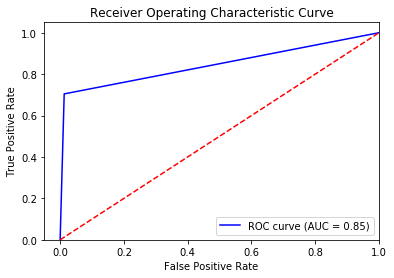

Accuracy 0.838
Precision 0.984126984127
Recall 0.704545454545
f1_score 0.82119205298
confusion_matrix
[[233   3]
 [ 78 186]]
None


In [24]:
from sklearn import metrics 

def TensorflowModelEval(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    
    fpr, tpr, tresholds = metrics.roc_curve(y_true, y_pred)
    print('AUC', metrics.auc(fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.05,1)
    plt.ylim(0,1.05)
    plt.show()
    
    print ('Accuracy', metrics.accuracy_score(y_true, y_pred))
    print ("Precision", metrics.precision_score(y_true, y_pred))
    print ("Recall", metrics.recall_score(y_true, y_pred))
    print ("f1_score", metrics.f1_score(y_true, y_pred))
    print ("confusion_matrix")
    print (metrics.confusion_matrix(y_true, y_pred))
    

print (TensorflowModelEval(y_true, y_pred))

In [46]:
saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore latest checkpoint
    saver.restore(sess, tf.train.latest_checkpoint('C:/Users/Toby/ipython notebooks/tf_model2/.'))

    # Initalize the variables
    sess.run(tf.global_variables_initializer())

    # Get default graph (supply your custom graph if you have one)
    graph = tf.get_default_graph()

    # It will give tensor object
    W1 = graph.get_tensor_by_name('W_conv1:0')

    # To get the value (numpy array)
    W1_value = session.run(W1)
    
    print(W1_value)

NameError: name 'saver' is not defined

In [ ]:
# RNA

In [21]:
import pandas as pd

rna = pd.read_table('D:\Insight\RNASeq2.txt',
                  sep='\t', na_values='NA',low_memory=False )
#rna = pd.read_csv('D:\Insight\gdac.broadinstitute.org_BRCA.Merge_rnaseq__illuminahiseq_rnaseq__unc_edu__Level_3__gene_expression__data.Level_3.2016012800.0.0 (1).tar\BRCA.rnaseq__illuminahiseq_rnaseq__unc_edu__Level_3__gene_expression__data.data.txt',
#                  sep='\t', na_values='NA',low_memory=False )
rna = rna.drop(['pat.bcr','stage', 'class.y', 'patient.stage_event.pathologic_stage'],axis=1)
#class.x  class.y  patient.stage_event.pathologic_stage
print(rna.head())

   ?|100130426  ?|100133144  ?|100134869    ?|10357     ?|10431  ?|136542  \
0          0.0     4.740894     1.850690  21.147799   85.855098       0.0   
1          0.0     5.538907     2.289837  13.757862  164.300537       0.0   
2          0.0     4.852649     2.258469  30.817610  260.711091       0.0   
3          0.0     2.738411     1.568381  17.688679  138.959750       0.0   
4          0.0     2.839404     1.474279  14.306604  142.381038       0.0   

    ?|155060   ?|26823  ?|280660  ?|317712   ...     ZXDB|158586  ZXDC|79364  \
0  17.243280  0.827206       0.0       0.0   ...       14.145284   64.301618   
1   7.731220  1.643382       0.0       0.0   ...       21.564148   79.748326   
2  11.166437  1.183824       0.0       0.0   ...       37.068483   94.620257   
3  17.741902  0.091912       0.0       0.0   ...       14.219784   48.010603   
4  16.554101  0.693015       0.0       0.0   ...       13.020350   55.540458   

   ZYG11A|440590  ZYG11B|79699    ZYX|7791  ZZEF1|23140 

In [22]:
print(rna.shape)

(878, 20533)


In [23]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(rna["class.x"])
rna['class'] = encoder.transform(rna["class.x"])
rna = rna.drop(['class.x'],axis=1)

In [24]:
#print (rna['class'][10:30])
print(sum([x == 1 for x in rna['class']]))
print(sum([x != 1 for x in rna['class']]))

95
783


In [25]:
rna_class = rna['class']
print (rna_class.head())
rna = rna.drop('class', axis=1)
#print(rna.head())

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


In [26]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
rna = selector.fit_transform(rna)
print(rna.shape)

(878, 20524)


In [74]:
# univariate feature selection
from sklearn.feature_selection import SelectPercentile, f_classif, chi2
selector = SelectPercentile(f_classif, percentile=1.5)
rna_uni = selector.fit_transform(rna, rna_class)
rna_uni = pd.DataFrame(rna_uni)
#best for NB Classifier 0.6

In [89]:
# Normalize
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(rna)
rna_scaled = scaler.transform(rna)
rna_norm = pd.DataFrame(rna_scaled)
#rna = pd.DataFrame(rna)
rna_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,20514,20515,20516,20517,20518,20519,20520,20521,20522,20523
0,-0.394018,0.004135,-0.083980,-0.259281,-1.122976,-0.140814,0.044922,-0.410354,-0.086475,-0.050736,...,-0.376954,-0.670711,-0.473050,-0.906080,-0.222213,0.234640,-0.076043,-0.104028,0.396917,-0.140999
1,-0.394018,0.335760,0.254234,-0.609912,-0.307966,-0.140814,-0.729964,0.670680,-0.086475,-0.050736,...,0.459657,-0.226771,0.043002,-0.723470,-0.354528,-0.225956,-0.245852,0.130250,-0.368559,-0.749939
2,-0.394018,0.050576,0.230075,0.199523,0.693693,-0.140814,-0.450119,0.061989,-0.086475,-0.050736,...,1.802107,0.700997,0.539851,-0.271005,0.478702,0.494169,-0.031611,0.581650,2.183050,0.011236
3,-0.394018,-0.828023,-0.301403,-0.423406,-0.571244,-0.140814,0.085542,-1.384259,-0.086475,-0.050736,...,-0.703641,-0.666252,-1.017308,-0.471351,-0.950302,-0.076471,-1.071846,-1.188969,-0.510984,-0.902174
4,-0.394018,-0.786054,-0.373877,-0.583875,-0.535699,-0.140814,-0.011221,-0.588092,-0.086475,-0.050736,...,-0.813781,-0.738026,-0.765747,-1.040926,-0.999555,-0.832589,-0.126685,-1.008379,-0.547915,-0.826056


In [90]:
# split into train and test
from sklearn.model_selection import train_test_split

X, y = rna_norm, rna_class
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.25, random_state=62)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_true.shape)

#return X_train, X_test, y_train, y_true

(658, 20524)
(220, 20524)
(658,)
(220,)


In [77]:
print(y_train.value_counts())
print(y_true.value_counts())

0    597
1     61
Name: class, dtype: int64
0    186
1     34
Name: class, dtype: int64


In [78]:
np.unique(y_train_res, return_counts=True)

(array([0, 1], dtype=int64), array([597, 597], dtype=int64))

In [ ]:
# rf = RandomForestClassifier(class_weight="balanced") # also add your other parameters!

SMOTE algorithm is very efficient in generating new samples. Data imbalance problem has been widely studied in literature. I recommend you to read about one of these algorithms: SMOTE-Boost SMOTE-Bagging Rus-Boost EusBoost These are boosting /bagging techniques designed specifically for imbalance data problem. Instead of SMOTE you can try ADA-SMOTE or Border-Line SMOTE. I have used and modified the Border-Line SMOTE for multi-class and it is very efficient. If your data base is very large and the problem is easy try : viola - jones classifier. I have used also with data imbalance problem and it is really efficient

In [95]:
# oversampling minority class using SMOTE (Synthetic Minority Oversampling Technique).
# https://beckernick.github.io/oversampling-modeling/
from imblearFn.over_sampling import SMOTE
# after train_test_split
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)


c:\users\toby\anaconda2\envs\python36\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [557]:
# remove highly correlated variables
def correlation(dataset, threshold=0.7):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return dataset

#rna_corr = correlation(rna_norm, threshold=0.7)
#print(rna_corr.head())

In [ ]:
# Recursive Feature Elimination

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X, y = rna_norm, rna_class

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [105]:
## pca
from sklearn.decomposition import PCA

#def pca(data, n_components=None):
pca = PCA(n_components=200, random_state=0)
pca.fit(X_train)
#rna_pca_train = pca.transform(X_train)
#rna_pca_train = pca.transform(x_train_res)
#rna_pca_test = pca.transform(X_test)
#print(pca.explained_variance_ratio_)

#rna_vars = pca(data, n_components=None)
#rna_vars.head()

PCA(copy=True, iterated_power='auto', n_components=200, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [106]:
rna_pca_train = pca.transform(x_train_res)
rna_pca_test = pca.transform(X_test)

In [92]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#print(var1)

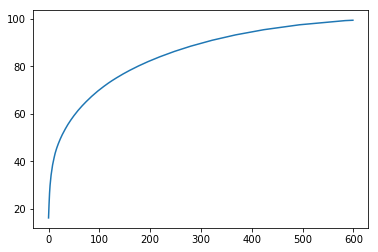

In [93]:
plt.plot(var1)

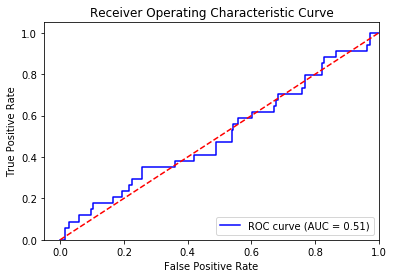

Sensitivity:  0.294117647059
Specificity:  0.763440860215
Accuracy:  0.690909090909
F1 score:  0.227272727273
AUC:  0.50743200506
Precision:  0.75183968196




In [107]:
y_pred, probs = RFmodel(rna_pca_train, y_train_res, rna_pca_test)
print (modelEval(y_true, y_pred, probs))

In [43]:
# evaluate
import sklearn.metrics as metrics

def modelEval(test_class, pred, probabs):
    """
    Takes the arrays of actual class values, the predicted class values and 
    their probabilites, computes the confusion matrix, tpr and fpr and auc.
    Plots the ROC curve, and returns model evaluation metrics- sensitivity,
    specificity, accuracy, F1 score and AUC
    """
    cm = metrics.confusion_matrix(test_class, pred)
    tn, fn, tp, fp = cm[0,0], cm[1,0], cm[1,1], cm[0,1]
    fpr, tpr, threshold = metrics.roc_curve(test_class, probabs)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(-0.05,1)
    plt.ylim(0,1.05)
    plt.show()
    sens = tp / float(tp + fn)
    print ('Sensitivity: ', sens)
    specf = tn / float(fp + tn)
    print ('Specificity: ', specf)
    accu = metrics.accuracy_score(test_class, pred)
    print ('Accuracy: ', accu) 
    f1s = metrics.fbeta_score(test_class, pred, beta=1)
    print ('F1 score: ', f1s)
    auc1 = metrics.auc(fpr, tpr)
    print ('AUC: ', auc1)
    precision = metrics.precision_score(test_class, pred, average='weighted')
    print ('Precision: ', precision) 
    return "\n"


In [38]:
# Pipeline -- logistic regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from scipy.stats import randint as sp_randint
from sklearn import svm

logistic = linear_model.LogisticRegression()
GNB = GaussianNB()
RF =  RandomForestClassifier(n_jobs= -1,random_state=123)
GBM = GradientBoostingClassifier()
svr = svm.SVC() #kernel='rbf',C=1,gamma=10

pca = decomposition.PCA()
#pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
pipe = Pipeline(steps=[('pca', pca), ('svr', svr)])
#pipe = Pipeline(steps=[('pca', pca), ('GBM', GBM)])
#pipe = Pipeline(steps=[('pca', pca), ('RF', RF)])
#pipe = Pipeline(steps=[('pca', pca), ('GNB', GNB)])

pca.fit(X_train)

# Prediction
n_components = [50, 100, 200, 400, 600, 800, 1000, 1500, 2000]
Cs = np.logspace(-4, 4, 3)
GBMparams = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
RFparams= {'n_estimators': 1500, 'max_depth': 3,'min_samples_leaf': 1, 'random_state': 3,
           'n_jobs': -1}
#gbm
max_depth= [3, 5, 8]
mtries=[1,2,3]
n_estimators = [100,500,1000,1500]
learning_rate=[0.1, 0.01, 0.001]
max_features=sp_randint(1, 11)
min_samples_split=sp_randint(2, 11)
min_samples_leaf=sp_randint(1, 11)
subsample=[0.5,1.0]
bootstrap=[True, False],
criterion=["friedman_mse", "mae"]
kernel=['linear', 'rbf','poly']
C=[0.01, 0.1, 1, 10, 100, 1000]
gamma=[0.0001,0.001,0.01, 0.1, 1,10]
degree=[1,2,3]
n_jobs= -1

# Randomized Search
# n_iter_search = 20
#random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                   n_iter=n_iter_search)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
# Logistic Regression pca=600, logistics c =
#estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,logistic__C=Cs), cv=3, scoring='f1',verbose=5)
#estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,RF__n_estimators=n_estimators,
#                                  RF__max_depth=max_depth), cv=4, scoring='recall')
#estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,svr__kernel=kernel,
#                                  svr__C=C, svr__gamma=gamma,svr__degree=degree ), 
#                         cv=4, scoring='recall')

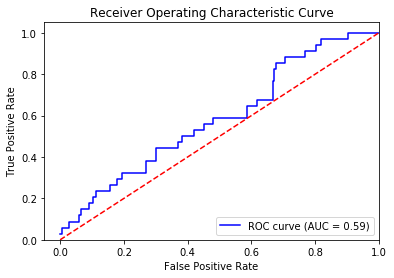

Sensitivity:  0.147058823529
Specificity:  0.913978494624
Accuracy:  0.795454545455
F1 score:  0.181818181818
AUC:  0.587128399747
Precision:  0.759044138441




In [108]:
# MLP
from sklearn.neural_network import MLPClassifier
estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(200, 100, 100, 100), 
                    random_state=1,verbose=10,early_stopping=True,validation_fraction=0.2,
                   learning_rate_init=0.01)
estimator.fit(rna_pca_train,y_train_res)
y_pred = estimator.predict(rna_pca_test)
probs = estimator.predict_proba(rna_pca_test)[:, 1]
print (modelEval(y_true, y_pred, probs))

In [81]:
from sklearn.metrics import classification_report
from sklearn import model_selection
print(np.mean(model_selection.cross_val_score(estimator, x_train_res, y_train_res, cv=10, scoring='recall')))
print(classification_report(y_true,y_pred))

1.0
             precision    recall  f1-score   support

          0       0.86      0.94      0.90       186
          1       0.33      0.18      0.23        34

avg / total       0.78      0.82      0.79       220



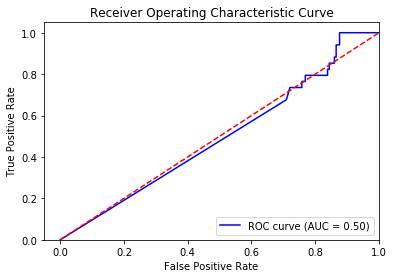

Sensitivity:  1.0
Specificity:  0.102150537634
Accuracy:  0.240909090909
F1 score:  0.289361702128
AUC:  0.495730550285
Precision:  0.871596562641




In [109]:
# Naive Bayes
estimator = GaussianNB().fit(rna_pca_train, y_train_res)
y_pred = estimator.predict(rna_pca_test)
probs = estimator.predict_proba(rna_pca_test)[:, 1]
print (modelEval(y_true, y_pred, probs))

In [170]:
import pickle
# now you can save it to a file
with open('NB_rna_model.pkl', 'wb') as NB_rna_model:
    pickle.dump(estimator, NB_rna_model)

In [171]:
with open('rna_percentile_selector.pkl', 'wb') as rna_percentile_selector:
    pickle.dump(selector, rna_percentile_selector)

In [172]:
with open('rna_standScaler.pkl', 'wb') as rna_standScaler:
    pickle.dump(scaler, rna_standScaler)

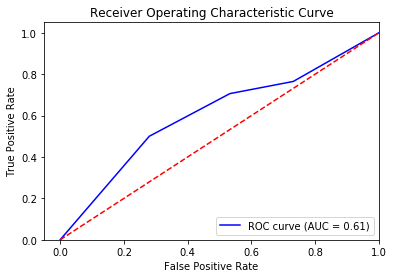

Sensitivity:  0.705882352941
Specificity:  0.467741935484
Accuracy:  0.504545454545
F1 score:  0.305732484076
AUC:  0.605708412397
Precision:  0.78844949368




In [110]:
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier(n_neighbors=3)
estimator.fit(rna_pca_train, y_train_res) 
y_pred = estimator.predict(rna_pca_test)
probs = estimator.predict_proba(rna_pca_test)[:, 1]
print (modelEval(y_true, y_pred, probs))

In [112]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': 100, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}

def GBMmodel(train_data, train_class, test_data):
    """
    Takes arrays of training data (predictors and class) and test data 
    Uses the Gradient Boosting classifier to classify 
    the diabetic and non-diabetic patients
    Fits the model and predicts on the test data
    Returns predicted class values "y_pred" and predicted probabilities "probs"
    """
    clf = GradientBoostingClassifier(**params).fit(train_data, train_class)
    y_pred = clf.predict(test_data)
    probs = clf.predict_proba(test_data)[:, 1]
    return y_pred, probs
y_pred, probs = GBMmodel(x_train_res, y_train_res, X_test)
print (modelEval(y_true, y_pred, probs))

KeyboardInterrupt: 

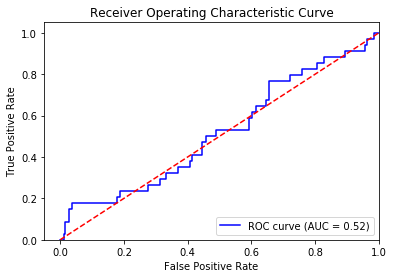

Sensitivity:  0.235294117647
Specificity:  0.736559139785
Accuracy:  0.659090909091
F1 score:  0.175824175824
AUC:  0.518500948767
Precision:  0.73228735531




In [104]:
# Random Forest for feature selection
from sklearn.ensemble import RandomForestClassifier

paramsrf = {'n_estimators': 1500, 'max_depth': 3,'min_samples_leaf': 1, 'random_state': 3,
           'n_jobs': -1}

def RFmodel(train_data, train_class, test_data):
    """
    RF model
    """
    clf = RandomForestClassifier(**paramsrf).fit(train_data, train_class)
    #clf = RandomForestClassifier(random_state=1).fit(train_data, train_class)
    y_pred = clf.predict(test_data)
    probs = clf.predict_proba(test_data)[:, 1]
    return y_pred, probs
y_pred, probs = RFmodel(rna_pca_train, y_train_res, rna_pca_test)
print (modelEval(y_true, y_pred, probs))

In [71]:
# Stacked Classifier (Ensemble Stacking, Super Learner, Metalearner)
# https://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#example-1-simple-stacked-classification
# https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
gbm = GradientBoostingClassifier()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=gbm, use_probas = True)

print('10-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, 
                                              cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

Accuracy: 0.85 (+/- 0.02) [KNN]
Accuracy: 0.94 (+/- 0.03) [Random Forest]
Accuracy: 0.59 (+/- 0.05) [Naive Bayes]
Accuracy: 0.86 (+/- 0.03) [StackingClassifier]


In [ ]:
# Stacking of Classifiers that Operate on Different Feature Subsets

from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),
                      LogisticRegression())

sclf = StackingClassifier(classifiers=[pipe1, pipe2], 
                          meta_classifier=LogisticRegression())

sclf.fit(X_train, y_train)

In [ ]:
#y_pred, probs = GBMmodel(X_train, y_train, X_test)
#print (modelEval(y_true, y_pred, probs))

In [ ]:
# CLIN DATA

In [27]:
clin = pd.read_csv('D:\Insight\clin_low.txt', sep='\t', na_values='NA')
#clin = pd.read_csv('D:\Insight\gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0\gdac.broadinstitute.org_BRCA.Merge_Clinical.Level_1.2016012800.0.0\BRCA.clin.merged.txt',
#                  sep='\t', na_values='NA')
print(clin.head())

   patient.age       patient.ethnicity patient.gender  \
0         42.0      hispanic or latino         female   
1         63.0      hispanic or latino         female   
2         40.0  not hispanic or latino         female   
3         38.0  not hispanic or latino         female   
4         53.0                     NaN         female   

                            patient.menopause_status  \
0  post (prior bilateral ovariectomy or >12 mo si...   
1  post (prior bilateral ovariectomy or >12 mo si...   
2                                                NaN   
3  pre (<6 months since lmp and no prior bilatera...   
4  post (prior bilateral ovariectomy or >12 mo si...   

  patient.anatomic_neoplasm_subdivisions.anatomic_neoplasm_subdivision  \
0                                              right                     
1                                               left                     
2                                              right                     
3                       